<a href="https://colab.research.google.com/github/albordunos/topic_modeling/blob/main/LDA_TG_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Установка необходимых библиотек
!pip install pandas xlrd nltk gensim pyLDAvis chardet matplotlib wordcloud plotly seaborn razdel pymorphy2 stopwords

# Импорт необходимых библиотек
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer  # Импортируем лемматизатор
import re
import string
from gensim import corpora
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import chardet
from gensim.models import Phrases  # Импортируем класс Phrases
from gensim.models.coherencemodel import CoherenceModel  # Импортируем CoherenceModel
import matplotlib.pyplot as plt  # Для визуализации
from wordcloud import WordCloud
import plotly.express as px
import seaborn as sns
from razdel import tokenize
from nltk.corpus import stopwords
import pymorphy2
import stopwords  # Импортируем библиотеку stopwords

# Загрузка ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
# === 1. Загрузка данных ===
# Укажите путь к файлу .csv
file_path = '/content/MID1.csv'

# Определение кодировки файла
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read(10000))
    detected_encoding = result['encoding']
    print(f"Определённая кодировка: {detected_encoding}")

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Определённая кодировка: UTF-16


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Чтение CSV-файла с использованием определенной кодировки и обработкой некорректных строк
df = pd.read_csv(file_path, encoding=detected_encoding, sep=';', on_bad_lines='skip')

# Вывод первых строк для проверки
print(df.head())

                        date  message_id  reply_to_msg_id   channel_name  \
0  2025-01-06 16:15:21+00:00       50411              NaN  МИД России 🇷🇺   
1  2025-01-06 16:00:02+00:00       50410              NaN  МИД России 🇷🇺   
2  2025-01-06 12:02:33+00:00       50409              NaN  МИД России 🇷🇺   
3  2025-01-06 10:15:02+00:00       50408              NaN  МИД России 🇷🇺   
4  2025-01-05 15:05:12+00:00       50407              NaN  МИД России 🇷🇺   

   channel_id  sender  sender_id  \
0  1065276858     NaN         -1   
1  1065276858     NaN         -1   
2  1065276858     NaN         -1   
3  1065276858     NaN         -1   
4  1065276858     NaN         -1   

                                             message   views  comments  \
0  ⚡️[**Комментарий**](https://mid.ru/ru/foreign_...  166781       NaN   
1  **🇷🇺🇲🇩 Заявление Посольства Российской Федерац...    4063       NaN   
2  ✍️ [Статья](https://globalaffairs.ru/articles/...    7134       NaN   
3  ❗️**Киевский режим не прекр

In [10]:
# Укажите название столбца с текстом
text_column = 'message'  # Замените на реальное название столбца

# Вывод информации о количестве строк и слов в исходных данных
num_rows = df.shape[0]
num_words = df[text_column].str.split().str.len().sum()  # Считаем общее количество слов в указанном столбце

print(f'Количество строк в исходных данных: {num_rows}')
print(f'Количество слов в исходных данных: {num_words}')

 # === 2. Предобработка текста ===
# Определение своих стоп-слов
custom_stop_words = ['мид', 'россия', 'россии', 'который', 'которые', 'которых', 'также', 'именно', 'включая', 'сегодня', 'лавров', 'захарова', 'минимтр', 'иностранных', 'дел', 'год', 'российский', 'федерация']

# Получаем стоп-слова для русского языка из библиотеки stopwords
russian_stop_words = stopwords.get_stopwords('ru')

# Объединяем с пользовательскими стоп-словами
stop_words = set(russian_stop_words + custom_stop_words)

# Инициализация лемматизатора
morph = pymorphy2.MorphAnalyzer()  # Инициализация лемматизатора pymorphy2

def preprocess_text(text):
    if pd.isna(text):  # Проверка на NaN
        return []

    # Приведение текста к нижнему регистру
    text = text.lower()

    # Удаление URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Удаляем URL

    # Удаление пунктуации и чисел, а также лишних пробелов
    text = re.sub(r'[^\w\s]', ' ', text)  # Заменяем пунктуацию на пробел
    text = re.sub(r'\d+', '', text)  # Удаляем числа
    text = re.sub(r'\s+', ' ', text)  # Заменяем несколько пробелов на один
    text = text.strip()  # Удаление пробелов в начале и конце строки

    # Токенизация текста
    tokens = word_tokenize(text)

    # Лемматизация токенов и фильтрация: удаление неалфавитных и стоп-слов
    filtered_tokens = [
        morph.parse(token.text)[0].normal_form
        for token in tokenize(text)
        if token.text.isalnum() and token.text not in stop_words and len(token.text) > 2
    ]

    return filtered_tokens  # Возвращаем список токенов


# Применение функции очистки текста к указанному столбцу
df['cleaned_text'] = df[text_column].astype(str).apply(preprocess_text)

# === 3. Создание n-грамм ===
# Создаем модель биграмм
bigram_model = Phrases(df['cleaned_text'], min_count=5, threshold=10)

# Применяем биграммную модель к очищенным токенам
df['bigrams'] = df['cleaned_text'].apply(lambda tokens: bigram_model[tokens])

# === 4. Создание корпуса и словаря ===
# Преобразуем очищенные тексты в список токенов
tokenized_texts = df['cleaned_text'].tolist()  # Получаем список списков токенов
tokenized_bigrams = df['bigrams'].tolist()  # Получаем список биграмм

# Создаем словарь (gensim Dictionary)
dictionary = corpora.Dictionary(tokenized_texts + tokenized_bigrams)

# Удаление редких и слишком частых слов (по желанию)
dictionary.filter_extremes(no_below=5, no_above=0.7)

# Создаем корпус (список мешков слов)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts + tokenized_bigrams]

# === 5. TF-IDF модель ===
# Применяем TF-IDF модель к корпусу
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Вывод статистики и первых строк для проверки
num_docs = len(tokenized_texts)
num_words = sum([len(tokens) for tokens in tokenized_texts])
print(f"Количество документов (строк): {num_docs}")
print(f"Общее количество слов: {num_words}")
print(df[['message', 'cleaned_text', 'bigrams']].head())

Количество строк в исходных данных: 47987
Количество слов в исходных данных: 3767056
Количество документов (строк): 47987
Общее количество слов: 2512658
                                             message  \
0  ⚡️[**Комментарий**](https://mid.ru/ru/foreign_...   
1  **🇷🇺🇲🇩 Заявление Посольства Российской Федерац...   
2  ✍️ [Статья](https://globalaffairs.ru/articles/...   
3  ❗️**Киевский режим не прекращает провокации с ...   
4  #ПреступленияКиевскогоРежима  [❗️ ](https://t....   

                                        cleaned_text  \
0  [комментарий, официальный, представитель, заха...   
1  [заявление, посольство, российский, федерация,...   
2  [статья, директор, департамент, внешнеполитиче...   
3  [киевский, режим, прекращать, провокация, цель...   
4  [преступлениякиевскогорежим, общественный, три...   

                                             bigrams  
0  [комментарий_официальный, представитель_захаро...  
1  [заявление, посольство, российский_федерация, ...  
2  [стат

In [11]:
#====6 обучение модели====
# Параметры для подбора количества тем
num_topics = int(input("Введите количество тем: "))

# Создание модели LDA с заданным количеством тем
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=5)

# Функция для получения доминирующей темы для документа
def get_dominant_topic(lda_model, doc_topics):
    return max(doc_topics, key=lambda item: item[1])

# Получение тем для всех документов
doc_topics = lda_model.get_document_topics(corpus)

# Вывод результатов
for idx, topic in lda_model.print_topics(-1):
    print('Тема: {}'.format(idx))
    print('Слова: {}'.format(topic))

    # Получение документов, относящихся к теме
    doc_topics = lda_model.get_document_topics(corpus)
    docs = [doc_id for doc_id, topic_values in enumerate(doc_topics) if max(topic_values, key=lambda x: x[1])[0] == idx]

    # Вывод номеров строк для темы
    print('Документы (строки):', docs)
    print()



Введите количество тем: 8
Тема: 0
Слова: 0.020*"российский" + 0.011*"связь" + 0.009*"сторона" + 0.008*"сми" + 0.007*"представитель" + 0.007*"журналист" + 0.007*"отношение" + 0.006*"вопрос" + 0.006*"информация" + 0.006*"российский_федерация"
Документы (строки): [5, 6, 20, 29, 116, 157, 168, 183, 184, 185, 187, 200, 201, 210, 273, 287, 313, 350, 359, 377, 385, 413, 427, 442, 462, 470, 539, 561, 612, 616, 643, 675, 690, 692, 716, 730, 731, 757, 766, 768, 790, 815, 847, 861, 873, 877, 881, 904, 912, 914, 933, 948, 1073, 1082, 1091, 1096, 1160, 1197, 1255, 1328, 1353, 1372, 1426, 1448, 1449, 1492, 1493, 1511, 1515, 1536, 1539, 1542, 1579, 1580, 1601, 1622, 1679, 1682, 1700, 1721, 1755, 1759, 1796, 1816, 1817, 1819, 1847, 1877, 1908, 1911, 1915, 1929, 1932, 1940, 2000, 2050, 2082, 2138, 2214, 2217, 2227, 2316, 2318, 2481, 2521, 2576, 2665, 2690, 2700, 2708, 2726, 2831, 2876, 2880, 2888, 2936, 2981, 3038, 3045, 3049, 3060, 3061, 3084, 3085, 3090, 3096, 3142, 3188, 3219, 3242, 3276, 3304, 3320

In [12]:
# === 7.1 Визуализация тем с помощью pyLDAvis ===
# Подготовка данных для визуализации
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

# --- 7.2. Распределение тем (pyLDAvis) ---
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.116331 -0.023259       1        1  24.293119
1      0.116776  0.166873       2        1  20.642162
7      0.068510  0.020600       3        1  13.912192
3      0.000990  0.239469       4        1  12.619146
0      0.114732 -0.002913       5        1  10.308262
6      0.016727 -0.271164       6        1   9.273803
4      0.041416 -0.145453       7        1   7.307080
5     -0.475482  0.015848       8        1   1.644236, topic_info=                       Term          Freq         Total Category  logprob  \
815            mediamessage  18943.000000  18943.000000  Default  30.0000   
927                 министр  19177.000000  19177.000000  Default  29.0000   
404               президент  10687.000000  10687.000000  Default  28.0000   
380                     оон  16001.000000  16001.000000  Default  27.0000   
291                 украина  16708.000000  16708.000000  Default  26.0000   
...                     ...           ...           ...      ...      ...   
4087               киргизия    438.631924    492.431010   Topic8  -5.1172   
24557   турецкий_республика    315.366008    480.076132   Topic8  -5.4472   
404               президент    774.541899  10687.326342   Topic8  -4.5486   
24545  республика_казахстан    259.837362    470.630027   Topic8  -5.6408   
23641       премьер_министр    279.328002   1799.812262   Topic8  -5.5685   

       loglift  
815    30.0000  
927    29.0000  
404    28.0000  
380    27.0000  
291    26.0000  
...        ...  
4087    3.9922  
24557   3.6877  
404     1.4834  
24545   3.5139  
23641   2.2448  

[571 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
815       8  0.999912  mediamessage
3972      1  0.083047        август
3972      2  0.062771        август
3972      3  0.009166        август
3972      4  0.239697        август
...     ...       ...           ...
814       3  0.268547        юнеско
814       5  0.730330        юнеско
1646      1  0.067614          язык
1646      3  0.800216          язык
1646      5  0.131743          язык

[1222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 8, 4, 1, 7, 5, 6])

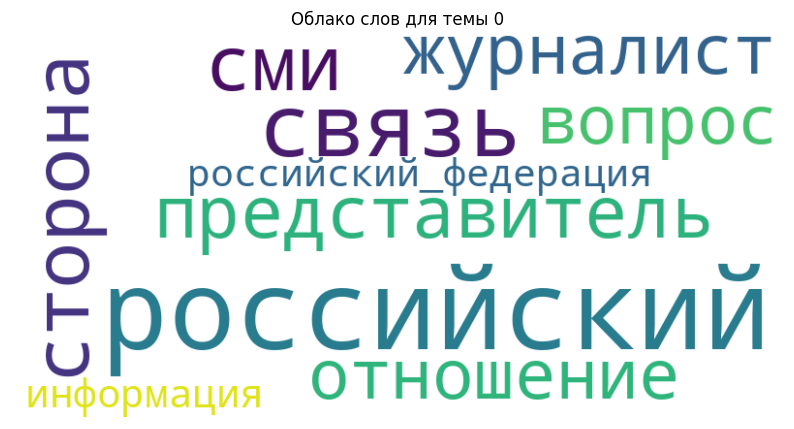

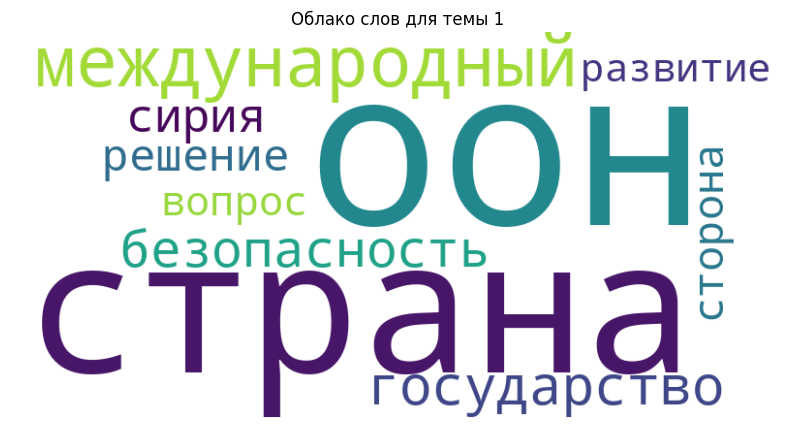

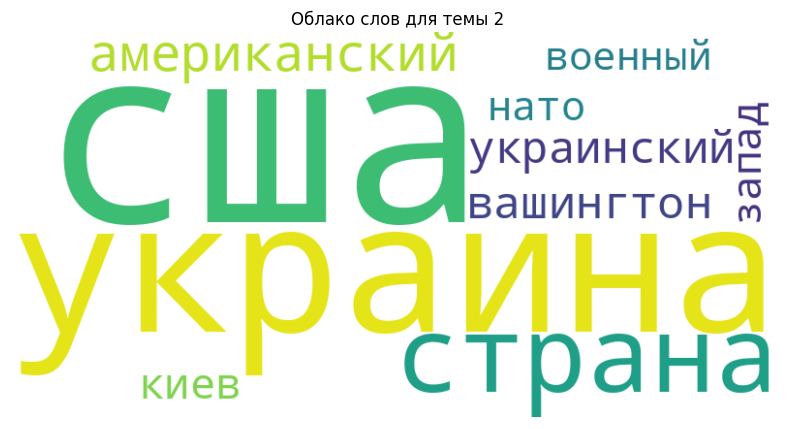

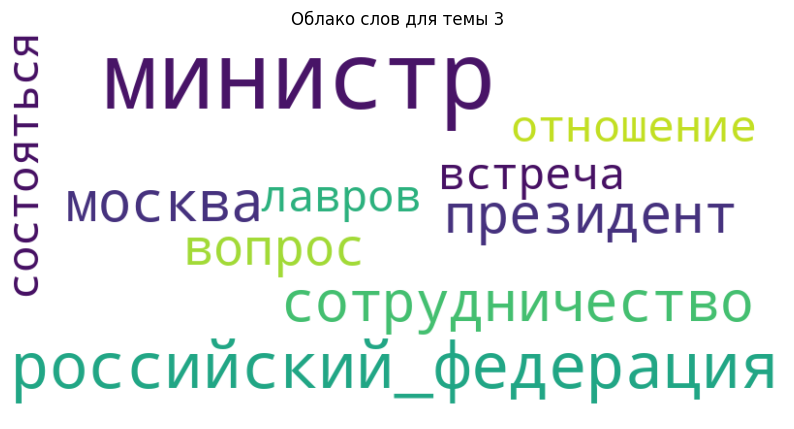

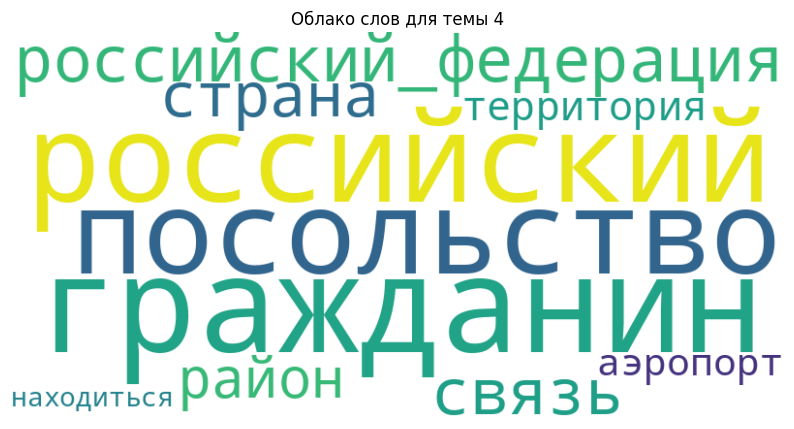

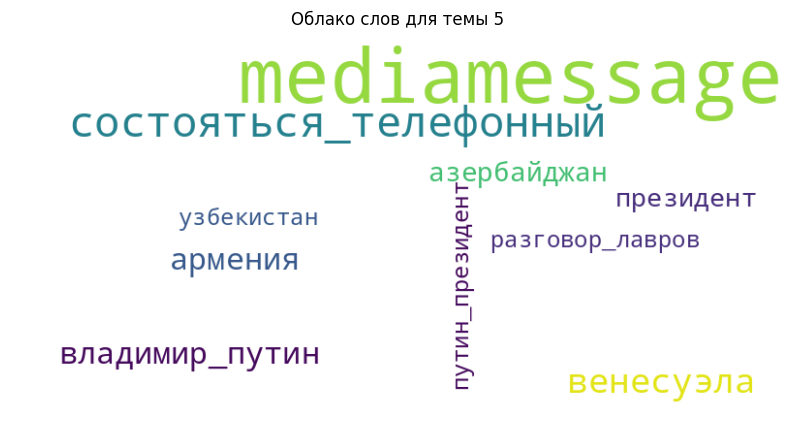

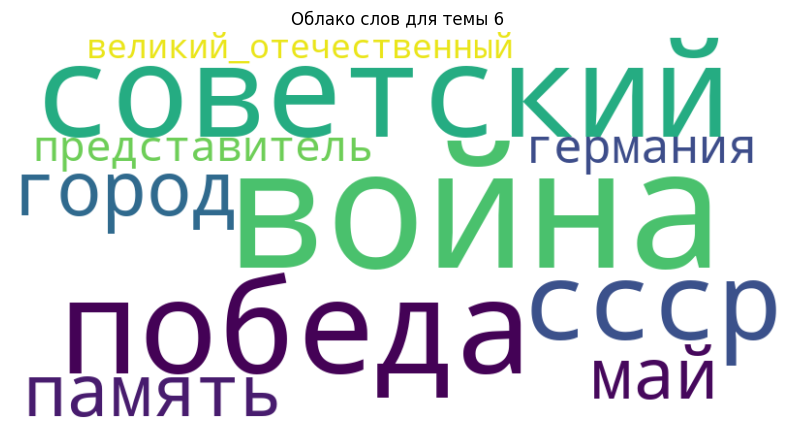

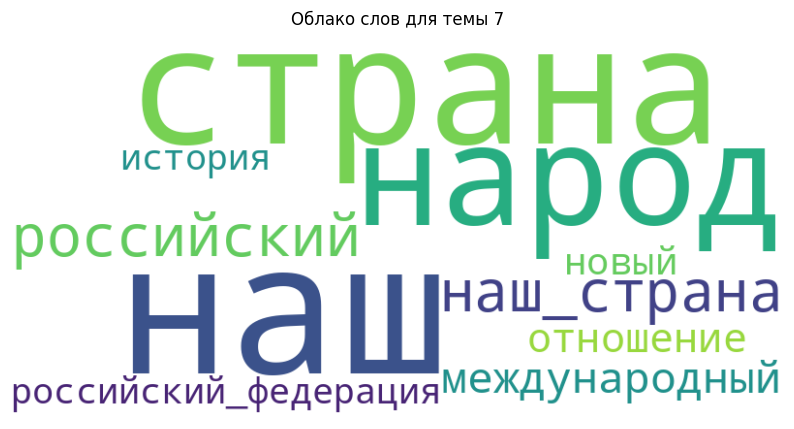

In [20]:
# === 8. Получение наиболее вероятных слов для каждой темы ===
topics_words = lda_model.show_topics(formatted=False)

# === 9. Облака слов для каждой темы ===
# Создание облака слов для каждой темы
for topic_id, topic in topics_words:
    word_freq = {word: freq for word, freq in topic}

    # Генерация облака слов
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Визуализация облака слов
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов для темы {topic_id}')
    plt.show()

In [65]:
#=== 10. Сохранение результатов ===
# Сохранение модели и словаря (по желанию)
lda_model.save('/content/lda_model.gensim')
dictionary.save('/content/dictionary.gensim')

# Сохранение очищенного текста
df.to_csv('/content/cleaned_texts.csv', index=False)
print("Результаты сохранены в файл: /content/cleaned_texts.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Результаты сохранены в файл: /content/cleaned_texts.csv


In [32]:
!pip install pandas openpyxl  # Для сохранения в .xlsx


# Функция для получения доминирующей темы для документа
def get_dominant_topic(doc_topics):
    return max(doc_topics, key=lambda item: item[1])

# Получение тем для всех документов
doc_topics = lda_model.get_document_topics(corpus)

# Список для хранения данных
data = []

# Вывод результатов и сбор данных
for idx, topic in lda_model.print_topics(-1):
    print('Тема: {}'.format(idx))
    print('Слова: {}'.format(topic))

    # Получение документов, относящихся к теме
    docs = [doc_id for doc_id, topic_values in enumerate(doc_topics) if get_dominant_topic(topic_values)[0] == idx]

    # Добавляем информацию о теме и связанных документах в список
    for doc_id in docs:
        data.append({'Topic ID': idx, 'Words': topic, 'Document ID': doc_id})

    # Вывод номеров строк для темы
    print('Документы (строки):', docs)
    print()

# Создание DataFrame из собранных данных
df = pd.DataFrame(data)

# Сохранение DataFrame в Excel файл
df.to_excel('/content/MID1.xlsx', index=False)  # Для .xlsx

print("Данные успешно сохранены в /content/MID1.xlsx")


Тема: 0
Слова: 0.020*"российский" + 0.011*"связь" + 0.009*"сторона" + 0.008*"сми" + 0.007*"представитель" + 0.007*"журналист" + 0.007*"отношение" + 0.006*"вопрос" + 0.006*"информация" + 0.006*"российский_федерация"
Документы (строки): [5, 6, 20, 29, 116, 157, 168, 183, 184, 185, 187, 200, 201, 210, 273, 287, 313, 350, 359, 377, 385, 413, 427, 442, 462, 470, 539, 561, 612, 616, 643, 675, 690, 692, 716, 730, 731, 757, 766, 768, 790, 815, 847, 861, 873, 877, 881, 904, 912, 914, 933, 948, 1073, 1082, 1091, 1096, 1160, 1197, 1255, 1328, 1353, 1372, 1426, 1448, 1449, 1492, 1493, 1511, 1515, 1536, 1539, 1542, 1579, 1580, 1601, 1622, 1679, 1682, 1700, 1721, 1755, 1759, 1796, 1816, 1817, 1819, 1847, 1877, 1908, 1911, 1915, 1929, 1932, 1940, 2000, 2050, 2082, 2138, 2214, 2217, 2227, 2316, 2318, 2481, 2521, 2576, 2665, 2690, 2700, 2708, 2726, 2831, 2876, 2880, 2888, 2936, 2981, 3038, 3045, 3049, 3060, 3061, 3084, 3085, 3090, 3096, 3142, 3188, 3219, 3242, 3276, 3304, 3320, 3336, 3434, 3435, 3468, 